<a href="https://colab.research.google.com/github/HamzaGbada/Backend/blob/master/Name_entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!mkdir sroie/
!unzip /content/drive/MyDrive/SROIE2019.zip -d sroie/

In [ ]:
import json
import os
from difflib import SequenceMatcher
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def read_bbox_and_words(path: Path):
    bbox_and_words_list = []

    with open(path, 'r', errors='ignore') as f:
        for line in f.read().splitlines():
            if len(line) == 0:
                continue

            split_lines = line.split(",")

            bbox = np.array(split_lines[0:8], dtype=np.int32)
            text = ",".join(split_lines[8:])

            # From the splited line we save (filename, [bounding box points], text line).
            # The filename will be useful in the future
            bbox_and_words_list.append([path.stem, *bbox, text])

    dataframe = pd.DataFrame(bbox_and_words_list,
                             columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'],
                             dtype=np.int16)
    dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

    return dataframe


def read_entities(path: Path):
    with open(path, 'r') as f:
        data = json.load(f)

    dataframe = pd.DataFrame([data])
    return dataframe


# Assign a label to the line by checking the similarity of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()

        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1

            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
                    (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
                    matches_count == len(entity_set):
                return column.upper()

    return "O"


def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
                       }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
                (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc + 4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


In [ ]:
import glob
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional, Callable

import numpy as np
import torch
from torch.utils.data import Dataset

In [ ]:
!mkdir sroie_csv/

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train):
        self.train = train
        self.train_path = '/content/sroie/SROIE2019/train/'
        if not self.train:
          self.train_path = '/content/sroie/SROIE2019/test/'
        
        self.data = []
        bbox_train_path = self.train_path + "box/"
        entities_train_path = self.train_path + "entities/"

        L = []
        d = {
             "address_mean":0,
             "company_mean":0,
             "date_mean":0,
             "total_mean":0
        }
        address = []
        company = []
        date = []
        total = []
        # Train Loop
        train_data = []
        bbox = list()
        for filename in os.listdir(bbox_train_path):
            bbox_file_path = bbox_train_path + filename
            entities_file_path = entities_train_path + filename

            bbox = read_bbox_and_words(path=Path(bbox_file_path))
            entities = read_entities(path=Path(entities_file_path))

            bbox_labeled = assign_labels(bbox, entities)
            bbox.append(bbox_labeled)
            bbox_labeled.to_csv("sroie_csv/"+filename[:-4]+".csv")
            s = ""
            L = []
            for i in range(len(bbox_labeled["line"])):
              s+=bbox_labeled["line"][i]+"\n"

              if bbox_labeled["label"][i] != 'O':
                L.append((len(s)-len(bbox_labeled["line"][i])-1, len(s)-2, bbox_labeled["label"][i]))

            train_data.append((s, {"entities": L}))
        print(bbox_labeled.head())
        print(train_data[-1])
        self.data = train_data
        print(type(bbox))
        df = pd.concat([bbox])
        df.to_csv("srroie_"+str(self.train)+".csv")


    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
dataset_train = CustomDataset(True)
# dataset_test = CustomDataset(False)

       filename   x0   y0    x2   y2                               line  \
0  X51005361946  912  372  1216  400             MR. D.I.Y. (M) SDN BHD   
1  X51005361946  943  398  1187  429                 (CO REG :860671-D)   
2  X51005361946  830  427  1283  457  LOT 1851-A & 1851-B, JALAN KPB 6,   
3  X51005361946  846  456  1268  484    KAWASAN PERINDUSTRIAN BALAKONG,   
4  X51005361946  860  483  1272  511     43300 SERI KEMBANGAN, SELANGOR   

     label  
0  COMPANY  
1        O  
2  ADDRESS  
3  ADDRESS  
4  ADDRESS  
('MR. D.I.Y. (M) SDN BHD\n(CO REG :860671-D)\nLOT 1851-A & 1851-B, JALAN KPB 6,\nKAWASAN PERINDUSTRIAN BALAKONG,\n43300 SERI KEMBANGAN, SELANGOR\n(GST ID NO :000306020352)\n(TESCO MUTIARA DAMANSARA)\nTAX INVOICE\nSOURING PAD 1018-4 4S\n*S\nWA03 - 24/240\n9555221301081\n4 X\nEXCHANGE ARE ALLOWED WITHIN\n2.80\n11.20\nSCISSOR G/FISH\n*S\nAD51 - 24/360\n9064422\n2 X\nOPERATOR TMDC - SAH BIJAY KUMAR\n1.50\n3.00\nTRAILING SKT 5GN+SP 3X1.25MM CABLE 2\n*S\nWA27 - 20\n9553114

In [ ]:
type(dataset_train[:])

list

In [ ]:
!pip install plac

In [ ]:
('SIZZLING STONEGRILL DIMILIKI OLEH : DOVE HOLDINGS SDN BHD REG NO : 91694-X LOT S25, AEON TEBRAU CITY JUSCO NO 1, JLN DESA TEBRAU, TMN DESA TEBRAU, 81100 JOHOR BAHRU, JOHOR +607-357 1177 GST ID: 0013 7941 8112 TAX INVOICE NO 15 80292 DATE: 26/05/2018 8:53:27 PM CASHIER: C001 TAX QTY CODE/DESC UNIT PRICE TOTAL RM SR 2 6.10 12.20 07 CREAM OF MUSHROOM SOUP SR 1 12.90 12.90 101 NOODLE SOUP O.T.ROCK SR 1 14.90 14.90 107 SPICY T/S SPAGHETTI SR 2 34.90 69.80 40 SIRLOIN STEAK SR 1 19.90 19.90 51 GRILLED MARINATED SR 1 18.90 18.90 54 GRILLED CHICKEN CHOP SR 1 6.90 6.90 99 ICED LEMON TEA TOTAL AMOUNT : 155.50 GST 6% 9.31 ROUNDING ADJ : -0.01 TOTAL AMOUNT: 164.80 TOTAL: RM 164.80 TYPE 7 QTY: 9 26/05/2018 8:53:37 GST SUMMARY AMOUNT RM TAX RM SR 6% 155.50 9.31 ZR 0% 0.00 0.00 ... XPOSMART WIFIPOS SINCE 1985 ... ', 
 {'entities': [(20, 57, 'COMPANY'), (75, 106, 'ADDRESS'), (107, 146, 'ADDRESS'), (147, 171, 'ADDRESS'), (233, 260, 'DATE'), (358, 359, 'ADDRESS'), (400, 401, 'ADDRESS'), (475, 476, 'ADDRESS'), (513, 514, 'ADDRESS'), (554, 555, 'ADDRESS'), (667, 676, 'TOTAL')]})

In [ ]:


('AEON CO. (M) BHD (126926-H) 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR GST ID : 002017394688 SHOPPING HOURS SUN-THU:1000 HRS - 2200 HRS FRI-SAT:1000 HRS - 2300 HRS 1X 000006142384 7.51SR MUNCHY`S CREAM 3X 000005709410 18.60SR TOPVALU BESTPRI @6.20 SUB-TOTAL 26.11 TOTAL SALES INCL GST 26.11 ROUNDING ADJ -0.01 TOTAL AFTER ADJ INCL GST 26.10 CASH 50.00 ITEM COUNT 4 CHANGE AMT 23.90 INVOICE NO: 2018042810080010325 GST SUMMARY AMOUNT TAX SR @ 6% 24.63 1.48 TOTAL 24.63 1.48 28/04/2018 15:35 1008 001 0010325 0304662 HEMADAS A/L BALOO AEON BANDAR PUCHONG TEL 1-300-80-AEON (2366) THANK YOU FOR YOUR PATRONAGE PLEASE COME AGAIN ', 
 {'entities': [(1, 28, 'COMPANY'), (29, 58, 'ADDRESS'), (59, 83, 'ADDRESS'), (84, 110, 'ADDRESS'), (375, 380, 'TOTAL'), (513, 529, 'DATE')]})


In [ ]:
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import spacy
from tqdm import tqdm 

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!mkdir ner/

In [ ]:
model = None
output_dir=Path("ner/")
n_iter=100

In [ ]:
if model is not None:
    nlp = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")
    

Created blank 'en' model


In [ ]:
if 'ner' not in nlp.pipe_names:
    # ner = nlp.create_pipe('ner')
    nlp.add_pipe('ner', last=True)
else:
    ner = nlp.get_pipe('ner')

In [ ]:
TRAIN_DATA = dataset_train[:]
TEST_DATA = dataset_test[:]

In [ ]:
from spacy.training.example import Example

for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in tqdm(TRAIN_DATA):
          doc = nlp.make_doc(text)
          example = Example.from_dict(doc, annotations)
          # Update the model
          nlp.update([example], losses=losses, drop=0.5, sgd=optimizer,)
          # nlp.update(
          #     [text],  
          #     [annotations],  
          #     drop=0.5,  
          #     sgd=optimizer,
          #     losses=losses)
        print(losses)

In [ ]:
for text, _ in TRAIN_DATA:
    doc = nlp(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

In [ ]:
if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)   

Saved model to ner


In [ ]:
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
for text, _ in TRAIN_DATA:
    doc = nlp2(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

In [ ]:
import pandas as pd
datapath = '/content/srroie_True.csv'
df = pd.read_csv(datapath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48 non-null     int64 
 1   filename    48 non-null     object
 2   x0          48 non-null     int64 
 3   y0          48 non-null     int64 
 4   x2          48 non-null     int64 
 5   y2          48 non-null     int64 
 6   line        48 non-null     object
 7   label       48 non-null     object
dtypes: int64(5), object(3)
memory usage: 3.1+ KB


In [ ]:
!ls sroie_csv/

In [ ]:
path = 'sroie_csv/' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

frame.to_csv("bob.csv")

In [ ]:
import pandas as pd
datapath = 'bob.csv'
df = pd.read_csv(datapath)
df.head()

<Axes: xlabel='label'>

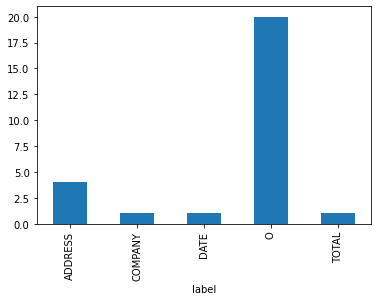

In [ ]:
df.groupby(['label']).size().plot.bar()


https://towardsdatascience.com/named-entity-recognition-with-bert-in-pytorch-a454405e0b6a

https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

https://towardsdatascience.com/custom-named-entity-recognition-with-bert-cf1fd4510804

https://github.com/Kanishkparganiha/Named-Entity-Recognition-using-BERT-with-PyTorch

https://github.com/sandipan/Blogs/blob/master/2020-09-08_Named-Entity-Recognition--NER--on-Twitter-using-Bi-directional-LSTM-with-tensorflow-in-python-8b85cccc649c.md

https://sandipanweb.wordpress.com/2020/08/30/named-entity-recognition-ner-on-twitter-with-bi-directional-lstm-with-tensorflow-in-python/

https://pythonalgos.com/using-nlp-to-get-insights-from-twitter/

https://www.analyticsvidhya.com/blog/2022/06/custom-named-entity-recognition-using-spacy-v3/

# NER with BERT

In [ ]:
!mkdir sroie/
!unzip /content/drive/MyDrive/SROIE2019.zip -d sroie/

In [2]:
import json
import os
from difflib import SequenceMatcher
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def read_bbox_and_words(path: Path):
    bbox_and_words_list = []

    with open(path, 'r', errors='ignore') as f:
        for line in f.read().splitlines():
            if len(line) == 0:
                continue

            split_lines = line.split(",")

            bbox = np.array(split_lines[0:8], dtype=np.int32)
            text = ",".join(split_lines[8:])

            # From the splited line we save (filename, [bounding box points], text line).
            # The filename will be useful in the future
            bbox_and_words_list.append([path.stem, *bbox, text])

    dataframe = pd.DataFrame(bbox_and_words_list,
                             columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'],
                             dtype=np.int16)
    dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

    return dataframe


def read_entities(path: Path):
    with open(path, 'r') as f:
        data = json.load(f)

    dataframe = pd.DataFrame([data])
    return dataframe


# Assign a label to the line by checking the similarity of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()

        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1

            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
                    (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
                    matches_count == len(entity_set):
                return column.upper()

    return "O"


def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
                       }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
                (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc + 4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


In [3]:
import glob
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional, Callable

import numpy as np
import torch
from torch.utils.data import Dataset

In [4]:
!mkdir sroie_csv/

In [5]:
class CustomDataset(Dataset):
    def __init__(self, train):
        self.train = train
        self.train_path = '/content/sroie/SROIE2019/train/'
        if not self.train:
          self.train_path = '/content/sroie/SROIE2019/test/'
        
        self.data = []
        bbox_train_path = self.train_path + "box/"
        entities_train_path = self.train_path + "entities/"

        L = []
        d = {
             "address_mean":0,
             "company_mean":0,
             "date_mean":0,
             "total_mean":0
        }
        address = []
        company = []
        date = []
        total = []
        # Train Loop
        train_data = []
        bbox = list()
        for filename in os.listdir(bbox_train_path):
            bbox_file_path = bbox_train_path + filename
            entities_file_path = entities_train_path + filename

            bbox = read_bbox_and_words(path=Path(bbox_file_path))
            entities = read_entities(path=Path(entities_file_path))

            bbox_labeled = assign_labels(bbox, entities)
            bbox.append(bbox_labeled)
            bbox_labeled.to_csv("sroie_csv/"+filename[:-4]+".csv")
            s = ""
            L = []
            for i in range(len(bbox_labeled["line"])):
              s+=bbox_labeled["line"][i]+"\n"

              if bbox_labeled["label"][i] != 'O':
                L.append((len(s)-len(bbox_labeled["line"][i])-1, len(s)-2, bbox_labeled["label"][i]))

            train_data.append((s, {"entities": L}))
        print(bbox_labeled.head())
        print(train_data[-1])
        self.data = train_data
        print(type(bbox))
        df = pd.concat([bbox])
        df.to_csv("srroie_"+str(self.train)+".csv")


    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
dataset = dataset_train = CustomDataset(True)


In [25]:
df_NER = pd.read_csv("/content/sroie_csv/X00016469612.csv")[["line", "label"]]
df_NER.head()

,line,label
0,TAN WOON YANN,O
1,BOOK TA .K(TAMAN DAYA) SDN BND,O
2,789417-W,O
3,"NO.53 55,57 & 59, JALAN SAGU 18,",ADDRESS
4,"TAMAN DAYA,",COMPANY


### def SROIE NER

In [38]:
def sroie_relabel(df_NER):
  ner_label = []

  for i in range(len(df_NER["line"])):
    nb_word = len(df_NER['line'][i].split())
    if df_NER["label"][i] == "O":
      ner_label.append("O " * nb_word)
    else:
      s = (" I-"+df_NER["label"][i]) * (nb_word-1)
      ner_label.append("B-"+df_NER["label"][i]+s)

  df_NER['ner_label'] = np.array(ner_label)
  return df_NER

In [28]:
df_NER1 = sroie_relabel(df_NER)

In [32]:
def convert_sroie_to_string(df_NER):
  lines = ""
  labels = ""
  L = []
  for i in range(len(df_NER["line"])):
    lines+=df_NER["line"][i]+" "
    labels+=df_NER["ner_label"][i]+" "
  return (lines, labels)

In [ ]:
df_NER1.head(100)

In [ ]:
convert_sroie_to_string(df_NER1)

In [39]:
def sroie_to_ner(sroie_csv_path):
  lines = []
  labels = []
  for filename in os.listdir(sroie_csv_path):
    file_path = sroie_csv_path + filename
    df_NER = pd.read_csv(file_path)[["line", "label"]]
    df_NER1 = sroie_relabel(df_NER)
    (line, label) = convert_sroie_to_string(df_NER1)
    lines.append(line)
    labels.append(labels)
  
  zipped = list(zip(lines, labels))
  df = pd.DataFrame(zipped, columns=['text', 'labels'])
  df.to_csv("sroie_NER.csv")
  return df

In [ ]:
df = sroie_to_ner("/content/sroie_csv/")
df.head()

## NER for kaggle dataset

In [ ]:
!pip install -q kaggle

# from google.colab import files
# files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d 'rajnathpatel/ner-data'
!unzip /content/ner-data.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/2.64M [00:00<?, ?B/s]
100% 2.64M/2.64M [00:00<00:00, 43.0MB/s]
Archive:  /content/ner-data.zip
  inflating: ner.csv                 


In [ ]:
%%capture
!pip install transformers

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer
from transformers import  DistilBertForTokenClassification

from torch.optim import AdamW

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

In [ ]:
import pandas as pd
import numpy as np

N = 1_000
df = pd.read_csv("/content/ner.csv").sample(frac=1)[:N]

#change columns names
df.rename(columns = {'text':'sentence', 'labels':'tags'}, inplace = True)

#split train, dev , test sets
df_train, df_dev, df_test = np.split(df.sample(frac=1, random_state=42),
                            [int(.8 * len(df)), int(.9 * len(df))])

In [ ]:
class DistilbertNER(nn.Module):
  """
  Implement NN class based on distilbert pretrained from Hugging face.
  Inputs : 
    tokens_dim : int specifyng the dimension of the classifier
  """
  
  def __init__(self, tokens_dim):
    super(DistilbertNER,self).__init__()
    
    if type(tokens_dim) != int:
            raise TypeError('Please tokens_dim should be an integer')

    if tokens_dim <= 0:
          raise ValueError('Classification layer dimension should be at least 1')

    self.pretrained = DistilBertForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels = tokens_dim) #set the output of each token classifier = unique_lables


  def forward(self, input_ids, attention_mask, labels = None): #labels are needed in order to compute the loss
    """
  Forwad computation of the network
  Input:
    - inputs_ids : from model tokenizer
    - attention :  mask from model tokenizer
    - labels : if given the model is able to return the loss value
  """

    #inference time no labels
    if labels == None:
      out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask )
      return out

    out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask , labels = labels)
    return out

In [ ]:
class NerDataset(torch.utils.data.Dataset):
  """
  Custom dataset implementation to get (text,labels) tuples
  Inputs:
   - df : dataframe with columns [tags, sentence]
  """
  
  def __init__(self, df):
    if not isinstance(df, pd.DataFrame):
      raise TypeError('Input should be a dataframe')
    
    if "tags" not in df.columns or "sentence" not in df.columns:
      raise ValueError("Dataframe should contain 'tags' and 'sentence' columns")

     
    
    tags_list = [i.split() for i in df["tags"].values.tolist()]
    texts = df["sentence"].values.tolist()

    self.texts = [tokenizer(text, padding = "max_length", truncation = True, return_tensors = "pt") for text in texts]
    self.labels = [match_tokens_labels(text, tags) for text,tags in zip(self.texts, tags_list)]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    batch_text = self.texts[idx]
    batch_labels = self.labels[idx]

    return batch_text, torch.LongTensor(batch_labels)

In [ ]:
class MetricsTracking():
  """
  In order make the train loop lighter I define this class to track all the metrics that we are going to measure for our model.
  """
  def __init__(self):

    self.total_acc = 0
    self.total_f1 = 0
    self.total_precision = 0
    self.total_recall = 0

  def update(self, predictions, labels , ignore_token = -100):
    '''
    Call this function every time you need to update your metrics.
    Where in the train there was a -100, were additional token that we dont want to label, so remove them.
    If we flatten the batch its easier to access the indexed = -100
    '''  
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    predictions = predictions[labels != ignore_token]
    labels = labels[labels != ignore_token]

    predictions = predictions.to("cpu")
    labels = labels.to("cpu")

    acc = accuracy_score(labels,predictions)
    f1 = f1_score(labels, predictions, average = "macro")
    precision = precision_score(labels, predictions, average = "macro")
    recall = recall_score(labels, predictions, average = "macro")

    self.total_acc  += acc
    self.total_f1 += f1
    self.total_precision += precision
    self.total_recall  += recall

  def return_avg_metrics(self,data_loader_size):
    n = data_loader_size
    metrics = {
        "acc": round(self.total_acc / n ,3), 
        "f1": round(self.total_f1 / n, 3), 
        "precision" : round(self.total_precision / n, 3), 
        "recall": round(self.total_recall / n, 3)
          }
    return metrics   

In [ ]:
def tags_2_labels(tags : str, tag2idx : dict):
  '''
  Method that takes a list of tags and a dictionary mapping and returns a list of labels (associated).
  Used to create the "label" column in df from the "tags" column.
  '''
  return [tag2idx[tag] if tag in tag2idx else unseen_label for tag in tags.split()]

In [ ]:
def tags_mapping(tags_series : pd.Series):
  """
  tag_series = df column with tags for each sentence.
  Returns:
    - dictionary mapping tags to indexes (label)
    - dictionary mappign inedexes to tags
    - The label corresponding to tag 'O'
    - A set of unique tags ecountered in the trainind df, this will define the classifier dimension
  """

  if not isinstance(tags_series, pd.Series):
      raise TypeError('Input should be a padas Series')

  unique_tags = set()
  
  for tag_list in df_train["tags"]:
    for tag in tag_list.split():
      unique_tags.add(tag)


  tag2idx = {k:v for v,k in enumerate(sorted(unique_tags))}
  idx2tag = {k:v for v,k in tag2idx.items()}

  unseen_label = tag2idx["O"]

  return tag2idx, idx2tag, unseen_label, unique_tags

In [ ]:
def match_tokens_labels(tokenized_input, tags, ignore_token = -100):
        '''
        Used in the custom dataset.
        -100 will be tha label used to match additional tokens like [CLS] [PAD] that we dont care about. 
        Inputs : 
          - tokenized_input : tokenizer over the imput text -> {input_ids, attention_mask}
          - tags : is a single label array -> [O O O O O O O O O O O O O O B-tim O]
        
        Returns a list of labels that match the tokenized text -> [-100, 3,5,6,-100,...]
        '''

        #gives an array [ None , 0 , 1 ,2 ,... None]. Each index tells the word of reference of the token
        word_ids = tokenized_input.word_ids()

        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:

            if word_idx is None:
                label_ids.append(ignore_token)

            #if its equal to the previous word we can add the same label id of the provious or -100 
            else :
                try:
                  reference_tag = tags[word_idx]
                  label_ids.append(tag2idx[reference_tag])
                except:
                  label_ids.append(ignore_token)
              
            
            previous_word_idx = word_idx

        return label_ids

In [ ]:
def freeze_model(model,num_layers = 1):
  """
  Freeze last num_layers of a model to prevent ctastrophic forgetting.
  Doesn't seem to work weel, its better to fine tune the entire netwok
  """
  for id , params in enumerate(model.parameters()):
    if id == len(list(model.parameters())) - num_layers: 
      print("last layer unfreezed")
      params.requires_grad = True
    else:
      params.requires_grad = False
  return model

In [ ]:
def train_loop(model, train_dataset, dev_dataset, optimizer,  batch_size, epochs):
  
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  for epoch in range(epochs) : 
    
    train_metrics = MetricsTracking()
    total_loss_train = 0

    model.train() #train mode

    for train_data, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      '''
      squeeze in order to match the sizes. From [batch,1,seq_len] --> [batch,seq_len] 
      '''
      mask = train_data['attention_mask'].squeeze(1).to(device)
      input_id = train_data['input_ids'].squeeze(1).to(device)

      optimizer.zero_grad()
      
      output = model(input_id, mask, train_label)
      loss, logits = output.loss, output.logits
      predictions = logits.argmax(dim= -1) 

      #compute metrics
      train_metrics.update(predictions, train_label)
      total_loss_train += loss.item()

      #grad step
      loss.backward()
      optimizer.step()
    
    '''
    EVALUATION MODE
    '''            
    model.eval()

    dev_metrics = MetricsTracking()
    total_loss_dev = 0
    
    with torch.no_grad():
      for dev_data, dev_label in dev_dataloader:

        dev_label = dev_label.to(device)

        mask = dev_data['attention_mask'].squeeze(1).to(device)
        input_id = dev_data['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask, dev_label)
        loss, logits = output.loss, output.logits

        predictions = logits.argmax(dim= -1)     

        dev_metrics.update(predictions, dev_label)
        total_loss_dev += loss.item()
    
    train_results = train_metrics.return_avg_metrics(len(train_dataloader))
    dev_results = dev_metrics.return_avg_metrics(len(dev_dataloader))

    print(f"TRAIN \nLoss: {total_loss_train / len(train_dataset)} \nMetrics {train_results}\n" ) 
    print(f"VALIDATION \nLoss {total_loss_dev / len(dev_dataset)} \nMetrics{dev_results}\n" )  

In [ ]:
#create tag-label mapping
tag2idx, idx2tag , unseen_label, unique_tags = tags_mapping(df_train["tags"])

#create the label column from tag. Unseen labels will be tagged as "O"
for df in [df_train, df_dev, df_test]:
  df["labels"] = df["tags"].apply(lambda tags : tags_2_labels(tags, tag2idx))

In [ ]:
text = df_train["sentence"].values.tolist()

#toeknized text
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_tokenized = tokenizer(text , padding = "max_length" , truncation = True, return_tensors = "pt" )

#mapping token to original word
word_ids = text_tokenized.word_ids()

In [ ]:
model = DistilbertNER(len(unique_tags))
#Prevent Catastrofic Forgetting
#model = freeze_model(model, num_layers = 2)

#datasets
train_dataset = NerDataset(df_train)
dev_dataset = NerDataset(df_dev)

lr = 1e-2
optimizer = SGD(model.parameters(), lr=lr, momentum = 0.9)  


#MAIN
parameters = {
    "model": model,
    "train_dataset": train_dataset,
    "dev_dataset" : dev_dataset,
    "optimizer" : optimizer,
    "batch_size" : 32,
    "epochs" : 8
}

train_loop(**parameters)

  0%|          | 0/25 [00:00<?, ?it/s]